In [2]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
# Import data
from os.path import dirname, join
from pathlib import Path
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR,"data","room_info.csv")  # requires `import os`

# input data
data_raw = pd.read_csv(r'C:\Users\milad\Documents\GitHub\arch7211-spring2021\data\room_info.csv')

In [4]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)

In [5]:
data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]

In [6]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [7]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 

In [17]:
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b
# quick view of the dataset grouped by type
data_tier2.groupby('type_cleaned').count().sort_values('')

,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,num_adjacent_walls,...,open_to_Storage,door_to_Storage,open_to_TechnicalRoom,door_to_TechnicalRoom,open_to_Undefined,door_to_Undefined,open_to_UserDefined,door_to_UserDefined,open_to_Utility,door_to_Utility
type_cleaned,,,,,,,,,,,,,,,,,,,,,
CarPort,279,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
Garage,414,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
Dining,954,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548


In [ ]:
#Clean input data from the target data
# define features and predictions
X = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1a.columns], axis =1)
y = data_tier1a['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)

In [4]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    n_estimators = 200,
                    subsample= 0.9,
                    colsample_bytree = 0.6)
print(xgb)

NameError: name 'XGBClassifier' is not defined

In [3]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=10,
        verbose=True)

NameError: name 'xgb' is not defined

In [101]:
evals_result = xgb.evals_result()

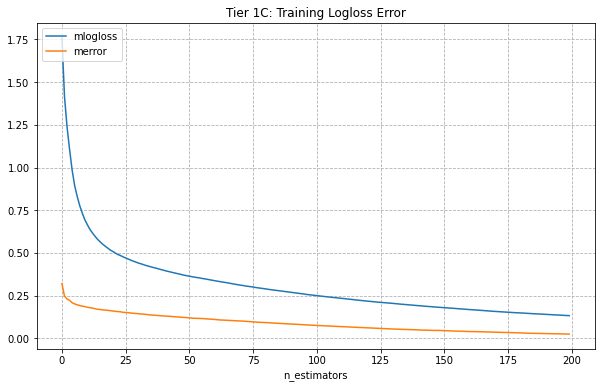

In [102]:
rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 1C: Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("Tier1C_mlogloss.png")
plt.show()
# plt.savefig('mlogloss_per_n_estimators.png')

In [103]:
train_score = xgb.score(X_train_train,y_train_train)
print("Tier 1C Training score: ",train_score)

Tier 1C Training score:  0.9747358479428605


In [104]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

200


In [105]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier1C_classificationReport.csv')
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

        Bath       0.79      0.82      0.80      2200
     Bedroom       0.77      0.91      0.83      2379
     CarPort       0.78      0.51      0.61        89
      Closet       0.61      0.62      0.61       912
      Dining       0.77      0.69      0.73       292
       Entry       0.86      0.89      0.88      1812
      Garage       0.67      0.69      0.68       114
     Kitchen       0.87      0.86      0.87      1363
  LivingRoom       0.78      0.86      0.82      1342
     Outdoor       0.96      0.96      0.96      2354
        Room       0.33      0.09      0.15       615
     Storage       0.69      0.66      0.67       579
     Utility       0.60      0.37      0.46       471

    accuracy                           0.80     14522
   macro avg       0.73      0.69      0.70     14522
weighted avg       0.79      0.80      0.79     14522



['Entry' 'Bedroom' 'LivingRoom' 'Outdoor' 'Bath' 'Closet' 'Storage'
 'Kitchen' 'Room' 'Dining' 'Utility' 'Garage' 'CarPort']
['Entry' 'Bedroom' 'LivingRoom' 'Outdoor' 'Bath' 'Closet' 'Storage'
 'Kitchen' 'Dining' 'Room' 'CarPort' 'Garage' 'Utility']


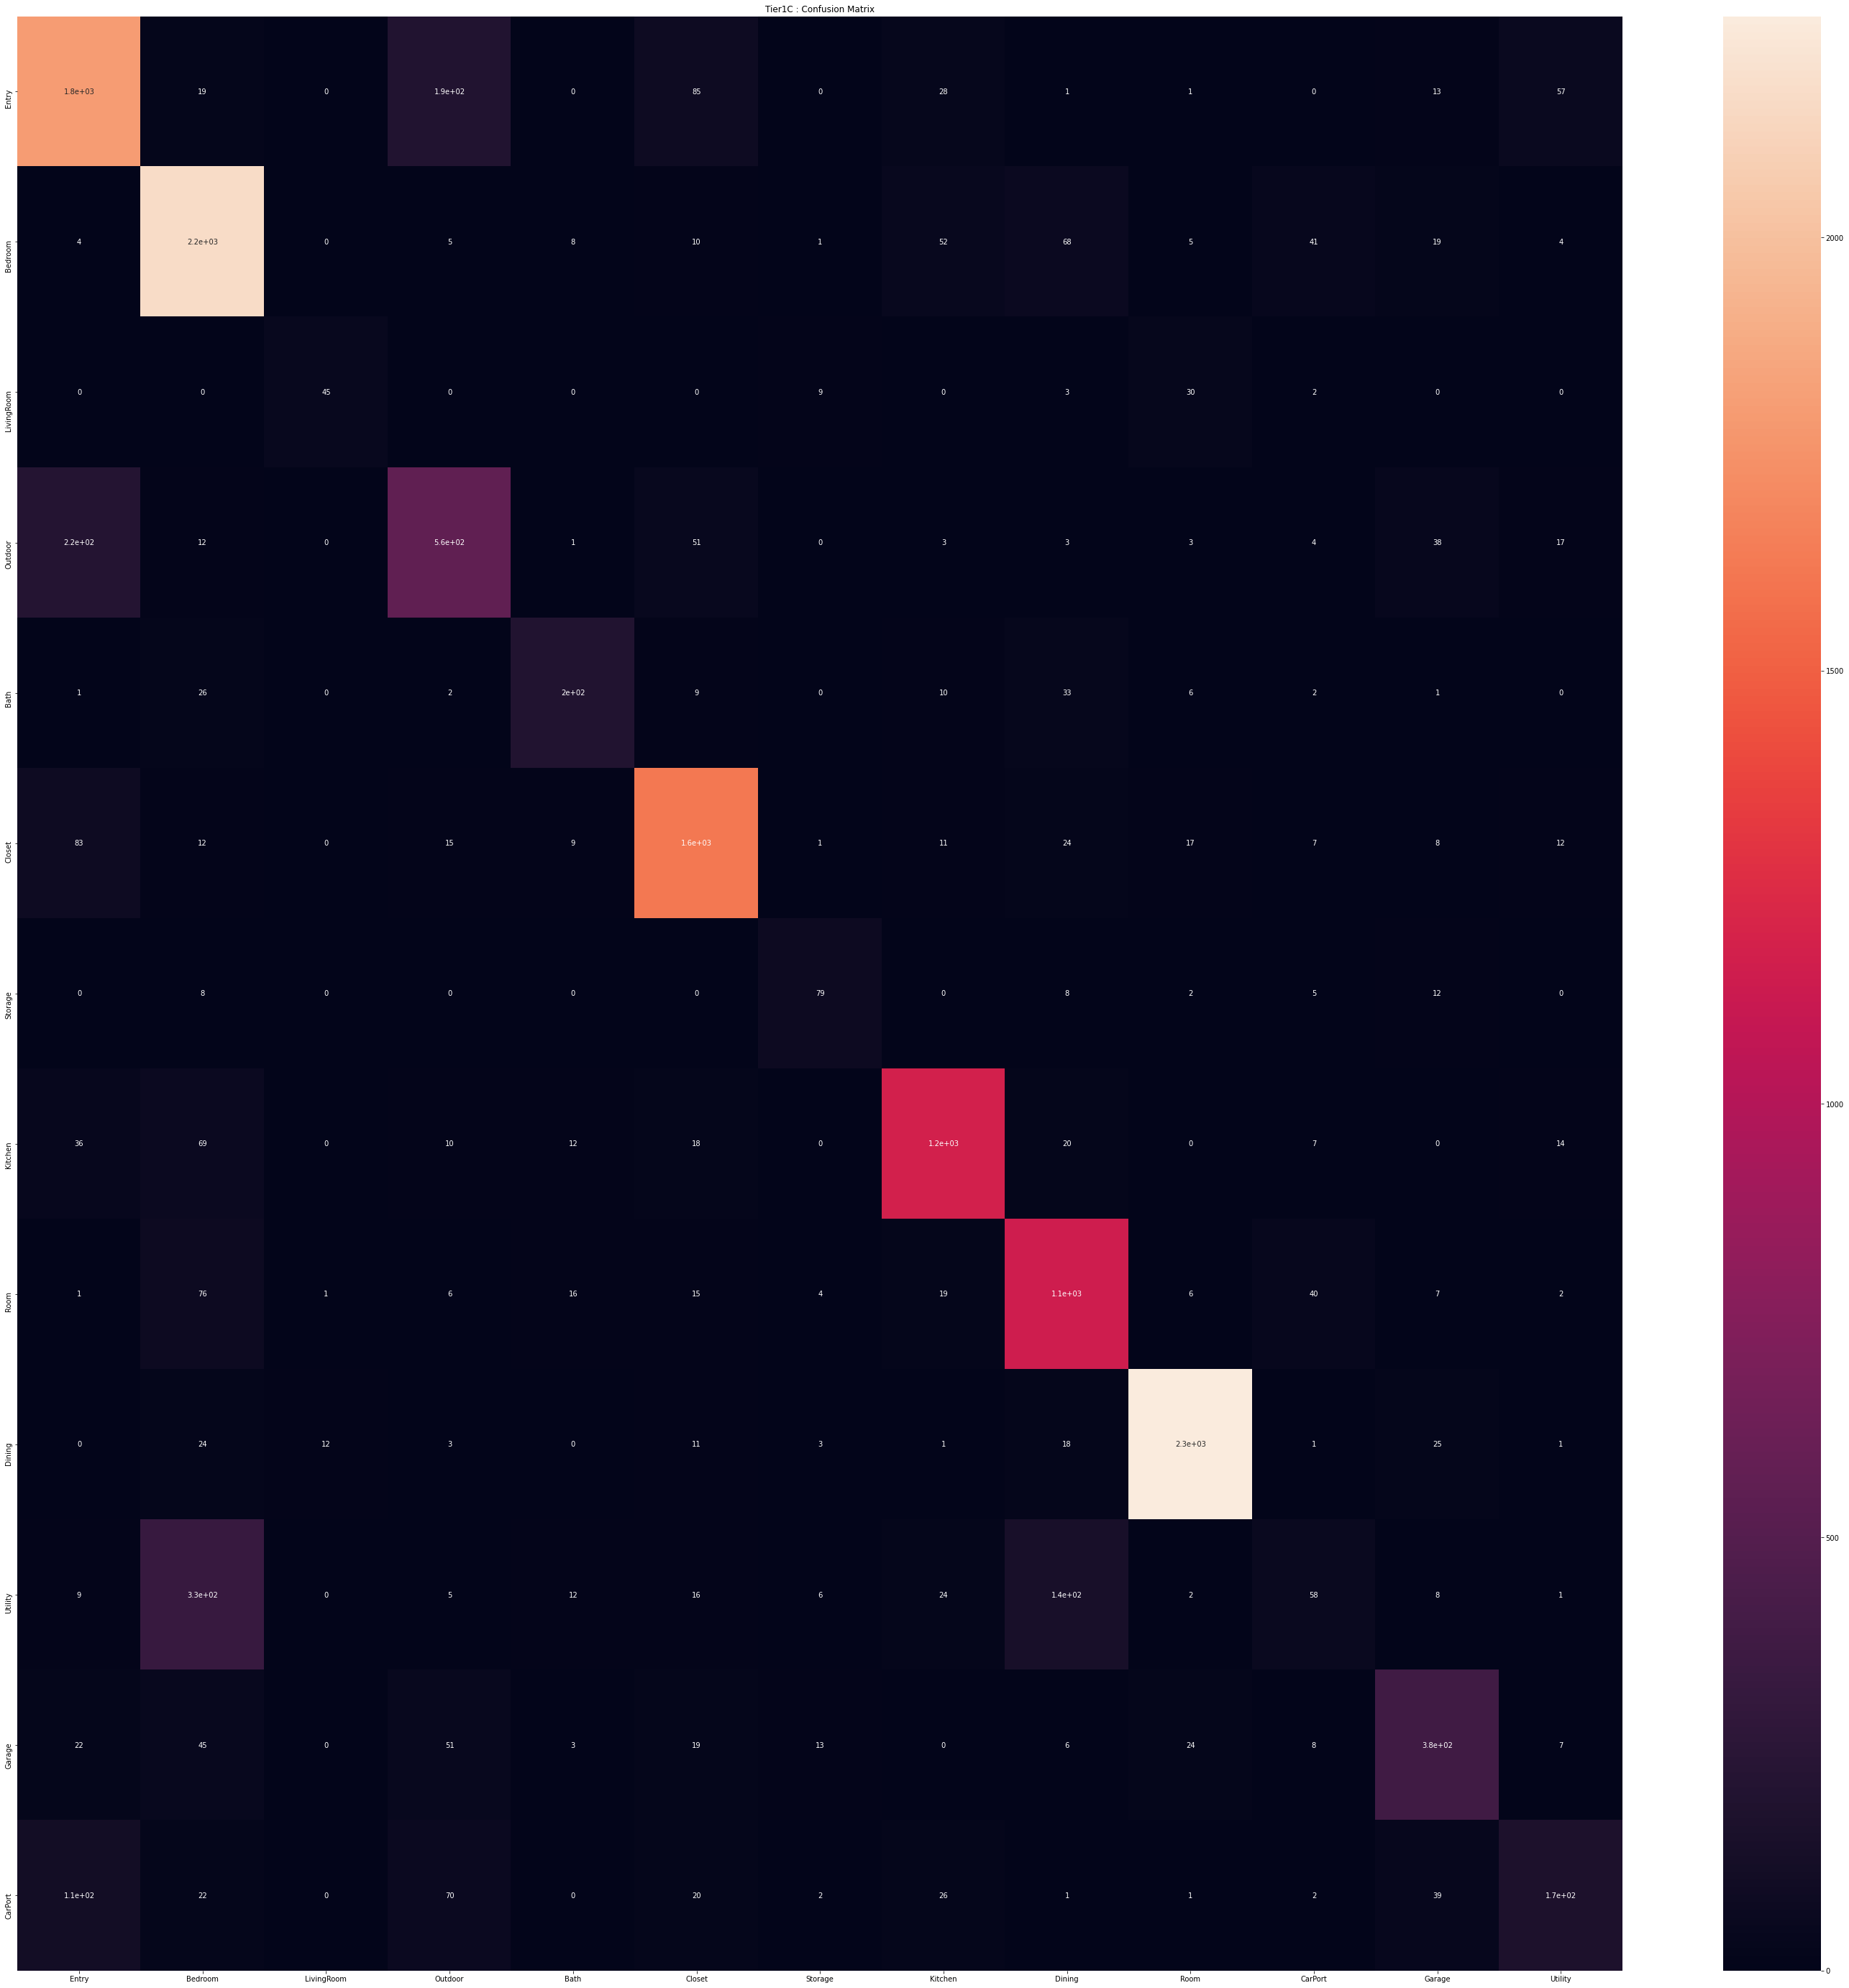

In [106]:
print(pd.Series(y_test).unique())
print(pd.Series(y_pred).unique())
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
sns.heatmap(df_cm, annot=True)
plt.title('Tier1C : Confusion Matrix')
plt.savefig('Tier1C_CM.png', dpi=100)
plt.show()

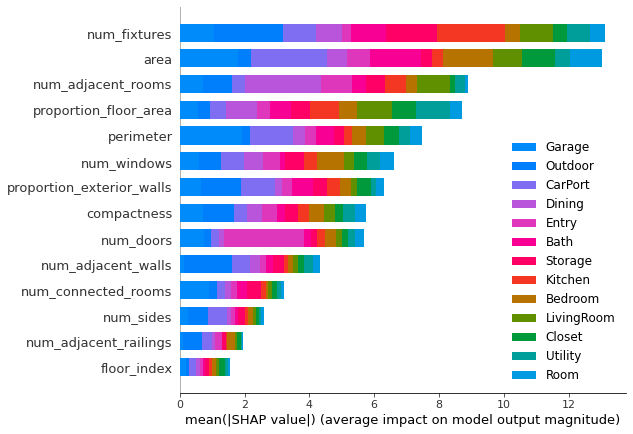

<Figure size 720x432 with 0 Axes>

In [109]:
# Feature importance
shap_values = shap.TreeExplainer(xgb).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=xgb.classes_, title='XGBoost Feature Importance')
plt.savefig('Tier 1c_featureImp.png',dpi=100)
plt.show()

In [116]:
#Grid Search based on best sub dataset (between tier1a, 1b, and 1c based on their classification reports)

#Grid Search

#Reproductability
seed = 342
np.random.seed(seed)
#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [5,6,7],
    'n_estimators' : [100,150,200,250],
    'learning_rate' : [0.01,0.1]

                }
params_fixed = {
    'objective' : 'multi:softprob',
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring='f1_macro')

In [117]:
fit_params = {
        'eval_set':[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        'eval_metric':['mlogloss'],
        'early_stopping_rounds':50
                }
bst_grid.fit(X_train_train,y_train_train,**fit_params)

gloss:0.37668	validation_1-mlogloss:0.63150
[80]	validation_0-mlogloss:0.37526	validation_1-mlogloss:0.63123
[81]	validation_0-mlogloss:0.37346	validation_1-mlogloss:0.63109
[82]	validation_0-mlogloss:0.37120	validation_1-mlogloss:0.63115
[83]	validation_0-mlogloss:0.36931	validation_1-mlogloss:0.63082
[84]	validation_0-mlogloss:0.36706	validation_1-mlogloss:0.63040
[85]	validation_0-mlogloss:0.36494	validation_1-mlogloss:0.63031
[86]	validation_0-mlogloss:0.36267	validation_1-mlogloss:0.63026
[87]	validation_0-mlogloss:0.36093	validation_1-mlogloss:0.63022
[88]	validation_0-mlogloss:0.35935	validation_1-mlogloss:0.63025
[89]	validation_0-mlogloss:0.35750	validation_1-mlogloss:0.63029
[90]	validation_0-mlogloss:0.35613	validation_1-mlogloss:0.63017
[91]	validation_0-mlogloss:0.35448	validation_1-mlogloss:0.63015
[92]	validation_0-mlogloss:0.35253	validation_1-mlogloss:0.63012
[93]	validation_0-mlogloss:0.35067	validation_1-mlogloss:0.63002
[94]	validation_0-mlogloss:0.34916	validation_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=N

In [118]:
print('Best params:',bst_grid.best_params_)

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [119]:
bst_pred = bst_grid.predict(X_test)

In [121]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier1C_bestparams_classificationReport.csv')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.79      0.82      0.80      2200
     Bedroom       0.77      0.91      0.83      2379
     CarPort       0.78      0.51      0.61        89
      Closet       0.61      0.62      0.61       912
      Dining       0.77      0.69      0.73       292
       Entry       0.86      0.89      0.88      1812
      Garage       0.67      0.69      0.68       114
     Kitchen       0.87      0.86      0.87      1363
  LivingRoom       0.78      0.86      0.82      1342
     Outdoor       0.96      0.96      0.96      2354
        Room       0.33      0.09      0.15       615
     Storage       0.69      0.66      0.67       579
     Utility       0.60      0.37      0.46       471

    accuracy                           0.80     14522
   macro avg       0.73      0.69      0.70     14522
weighted avg       0.79      0.80      0.79     14522



In [18]:
# TIER 2 -------------------------

#Clean input data from the target data
# define features and predictions
X = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier2.columns], axis =1)
y = data_tier2['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)

In [20]:
#XGB default parameters
model = XGBClassifier(objective='multi:sofprob',
                    n_estimators = 100,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    learning_rate= 0.1,
                    max_depth= 7)
print(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=7,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:sofprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [22]:
model.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

[0]	validation_0-mlogloss:2.18447	validation_0-merror:0.20412	validation_1-mlogloss:2.19625	validation_1-merror:0.23037
[1]	validation_0-mlogloss:1.94188	validation_0-merror:0.18405	validation_1-mlogloss:1.96186	validation_1-merror:0.21031
[2]	validation_0-mlogloss:1.75580	validation_0-merror:0.16959	validation_1-mlogloss:1.78452	validation_1-merror:0.19703
[3]	validation_0-mlogloss:1.60924	validation_0-merror:0.15967	validation_1-mlogloss:1.64442	validation_1-merror:0.18847
[4]	validation_0-mlogloss:1.48180	validation_0-merror:0.15401	validation_1-mlogloss:1.52300	validation_1-merror:0.18233
[5]	validation_0-mlogloss:1.38198	validation_0-merror:0.14964	validation_1-mlogloss:1.42866	validation_1-merror:0.17938
[6]	validation_0-mlogloss:1.29168	validation_0-merror:0.14769	validation_1-mlogloss:1.34335	validation_1-merror:0.17772
[7]	validation_0-mlogloss:1.21403	validation_0-merror:0.14550	validation_1-mlogloss:1.27020	validation_1-merror:0.17648
[8]	validation_0-mlogloss:1.14690	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
evals_result = model.evals_result()

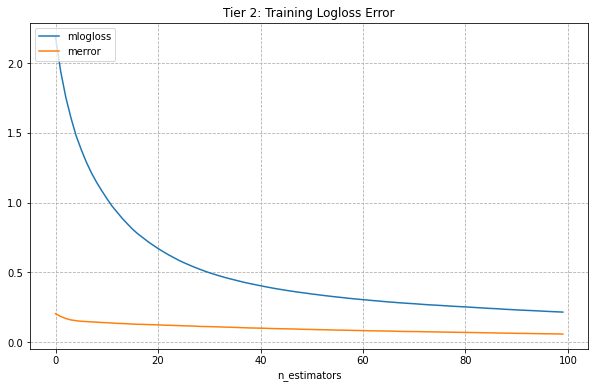

In [24]:
rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 2: Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("Tier2_mlogloss.png")
plt.show()
# plt.savefig('mlogloss_per_n_estimators.png')

In [25]:
train_score = model.score(X_train_train,y_train_train)
print("Tier 2 Training score: ",train_score)

Tier 2 Training score:  0.9419160616256419


In [26]:
best_iteration = model.get_booster().best_ntree_limit
y_pred = model.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

100


In [28]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier2_bestparams_classificationReport.csv')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.86      0.91      0.89      2190
     Bedroom       0.80      0.92      0.86      2388
     CarPort       0.77      0.50      0.61        94
      Closet       0.77      0.72      0.74       931
      Dining       0.88      0.87      0.87       300
       Entry       0.92      0.95      0.93      1902
      Garage       0.67      0.77      0.72       126
     Kitchen       0.89      0.89      0.89      1364
  LivingRoom       0.82      0.87      0.84      1266
     Outdoor       0.96      0.96      0.96      2326
        Room       0.37      0.12      0.18       617
     Storage       0.73      0.73      0.73       586
     Utility       0.73      0.54      0.62       432

    accuracy                           0.85     14522
   macro avg       0.78      0.75      0.76     14522
weighted avg       0.84      0.85      0.84     14522



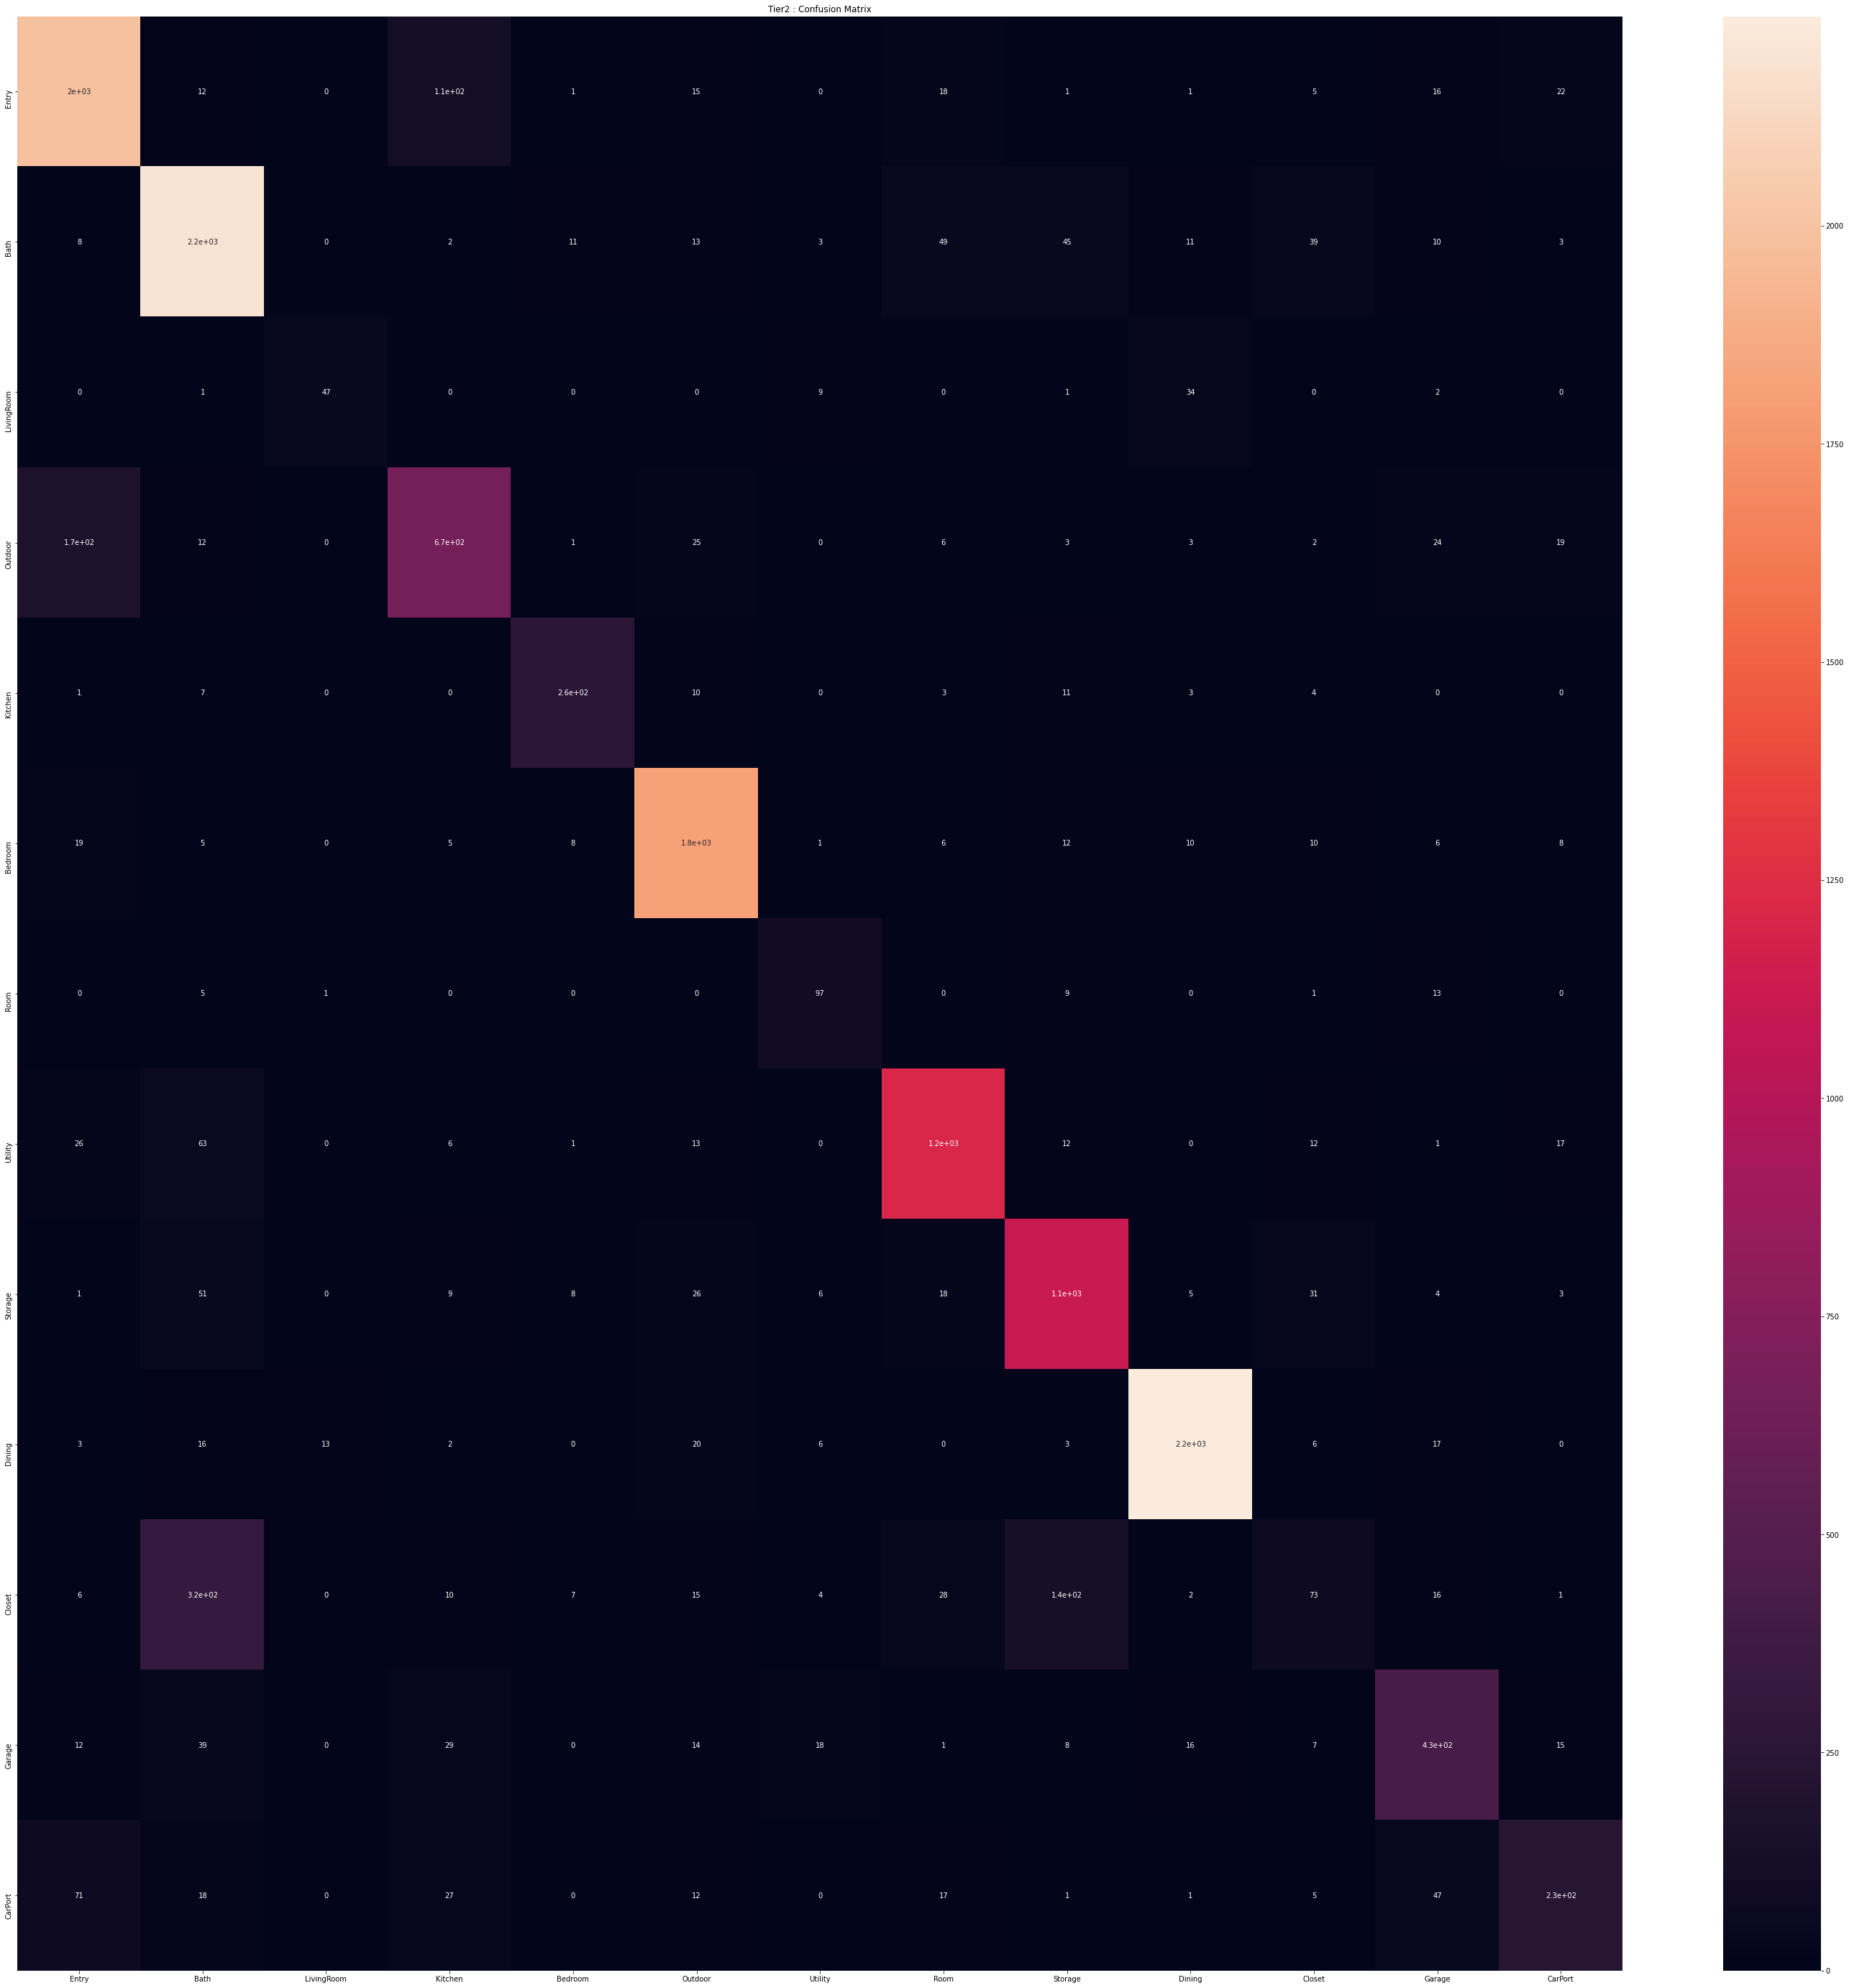

In [29]:
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
sns.heatmap(df_cm, annot=True)
plt.title('Tier2 : Confusion Matrix')
plt.savefig('Tier2_CM.png', dpi=100)
plt.show()

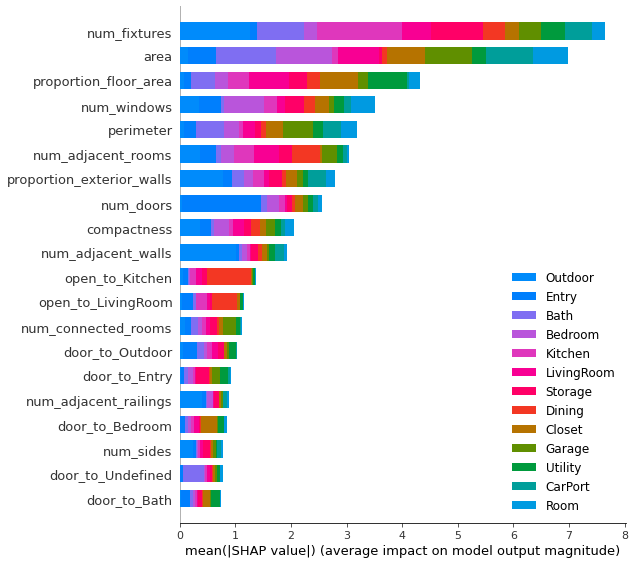

<Figure size 720x432 with 0 Axes>

In [30]:
# Feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model.classes_, title='XGBoost Feature Importance')
plt.savefig('Tier 2_featureImp.png',dpi=100)
plt.show()

In [69]:
#Model Final
# TIER 3 -------WHOLE DATA---------

#Clean input data from the target data
# define features and predictions
X = data_cleaned.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_cleaned.columns], axis =1)
y = data_cleaned['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.5)

#model parameters
model = XGBClassifier(objective='multi:sofprob',
                    n_estimators = 1000,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    learning_rate= 0.005,
                    max_depth= 6)
print(model)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:sofprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [70]:
model.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.51785	validation_0-merror:0.09687	validation_1-mlogloss:0.57427	validation_1-merror:0.11764
[515]	validation_0-mlogloss:0.51697	validation_0-merror:0.09692	validation_1-mlogloss:0.57349	validation_1-merror:0.11770
[516]	validation_0-mlogloss:0.51612	validation_0-merror:0.09687	validation_1-mlogloss:0.57271	validation_1-merror:0.11752
[517]	validation_0-mlogloss:0.51528	validation_0-merror:0.09687	validation_1-mlogloss:0.57196	validation_1-merror:0.11758
[518]	validation_0-mlogloss:0.51446	validation_0-merror:0.09687	validation_1-mlogloss:0.57122	validation_1-merror:0.11758
[519]	validation_0-mlogloss:0.51365	validation_0-merror:0.09681	validation_1-mlogloss:0.57048	validation_1-merror:0.11746
[520]	validation_0-mlogloss:0.51285	validation_0-merror:0.09657	validation_1-mlogloss:0.56977	validation_1-merror:0.11740
[521]	validation_0-mlogloss:0.51201	validation_0-merror:0.09657	validation_1-mlogloss:0.56901	validation_1-merror:0.11752
[522]	validation_0-mlogloss:0.51

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
evals_result = model.evals_result()

In [67]:
train_score = model.score(X_train_train,y_train_train)
print("Tier 2 Training score: ",train_score)

Tier 2 Training score:  0.8750368927454105


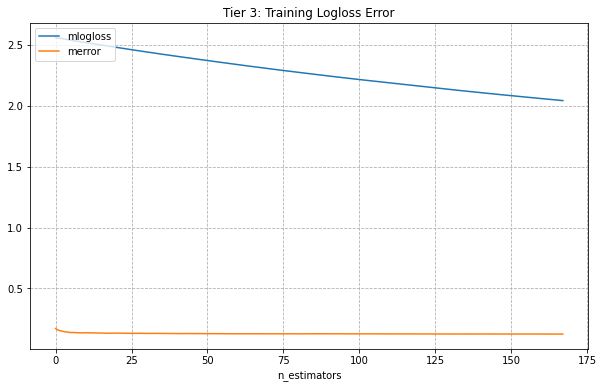

In [68]:
rcParams['figure.figsize'] = 10,6

plt.plot(evals_result.get('validation_0').get('mlogloss'))
plt.plot(evals_result.get('validation_0').get('merror'))
# plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 3: Training Logloss Error')
plt.legend(('mlogloss','merror'),loc=2)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig("Tier3_mlogloss.png")
plt.show()

In [52]:
best_iteration = model.get_booster().best_ntree_limit
y_pred = model.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

993


In [53]:
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv('Tier3_bestparams_classificationReport.csv')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.97      0.96      0.96      2211
     Bedroom       0.81      0.95      0.88      2387
     CarPort       0.83      0.58      0.68        78
      Closet       0.87      0.87      0.87       954
      Dining       0.88      0.87      0.88       271
       Entry       0.93      0.97      0.95      1769
      Garage       0.84      0.70      0.76       118
     Kitchen       0.98      0.95      0.96      1445
  LivingRoom       0.84      0.92      0.88      1309
     Outdoor       0.97      0.97      0.97      2311
        Room       0.41      0.13      0.19       651
     Storage       0.73      0.75      0.74       584
     Utility       0.85      0.72      0.78       434

    accuracy                           0.89     14522
   macro avg       0.84      0.80      0.81     14522
weighted avg       0.88      0.89      0.88     14522

